## Advanced Lane Finding Project

The goals / steps of this project are the following:

1 - Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

2 - Apply a distortion correction to raw images.

3 - Use color transforms, gradients, etc., to create a thresholded binary image.

4 - Apply a perspective transform to rectify binary image ("birds-eye view").

5 - Detect lane pixels and fit to find the lane boundary.

6 - Determine the curvature of the lane and vehicle position with respect to center.

7 - Warp the detected lane boundaries back onto the original image.

8 - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Libraries used in the project

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
from moviepy.editor import VideoFileClip
%matplotlib inline

### Helper Functions

In [2]:
def Calculate_Sobel(warpedimage, orient,  thresh_min=0, thresh_max=255, kernelSize=3):
    
    # 1) Convert to gray scale
    gray = cv2.cvtColor(warpedimage, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernelSize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernelSize)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Get gradient as per orientation passed
    if orient=='x':
        grad = abs_sobelx
    elif orient == 'y':
        grad = abs_sobely
    elif orient == 'xy':
        grad= abs_sobelxy
    elif orient == 'dir':
        grad = np.arctan2(abs_sobely, abs_sobelx)
        
    # 5) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*grad/np.max(grad))
    
    # 6) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # 7) Return this mask as your binary_output image
    return binary_output    

In [3]:
def hls_threshold(img, channel, thresh=(0, 255)):
    # Convert from RGB to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Extract channels needed H/L/S from the image
    if channel == 'h':
        channelImg = hls[:,:,0]
    elif channel == 'l':
        channelImg = hls[:,:,1]
    elif channel == 's':
        channelImg = hls[:,:,2]
    
    hlsBinary = np.zeros_like(channelImg)
    hlsBinary[(channelImg > thresh[0]) & (channelImg <= thresh[1])] = 1
    return hlsBinary

In [4]:
def region_of_interest(img):
    mask = np.zeros_like(img)   
    
    imshape = img.shape    
    if len(imshape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    # Define the vertices of region of interest
    vertices = np.array([[(0,imshape[0]),(imshape[1]*0.48, imshape[0]*0.58), (imshape[1]*0.52, imshape[0]*0.58), (imshape[1],imshape[0])]], dtype=np.int32)              
    cv2.fillPoly(mask, vertices, ignore_mask_color)   
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Functions of searching for lane lines either blindly or around the previously detected lanes

In [5]:
def find_lane_pixels_blind(binary_warped):
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 5) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 5) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found number of indices > minpix parameter, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return leftx, lefty, rightx, righty, out_img, left_fit, right_fit

In [6]:
def search_around_poly(binary_warped,left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search around it
    margin = 100
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    # within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    # Calculate both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return leftx, lefty, rightx, righty, result, left_fit,right_fit

In [7]:
def fit_polynomial(binary_warped,is_First_Frame=True,left_fit=0,right_fit=0):

    if (is_First_Frame == True):
         # First frame so search blindly for lane lines
        leftx, lefty, rightx, righty, out_img, left_fit, right_fit = find_lane_pixels_blind(binary_warped)
    else:
        # In case of video we already have history of where can we search for lane lines
        leftx, lefty, rightx, righty, out_img, left_fit, right_fit = search_around_poly(binary_warped,left_fit,right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit

In [8]:
def draw_lanes(image,warped, left_fitx, right_fitx, ploty, Minv):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    return newwarp

## Statistics Helper Functions

In [9]:
def measure_curvature_pixels(img_width, leftx, rightx, ploty):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curverad = int((left_curverad + right_curverad) / 2)

    # Calculate left lane position
    left_lane_pos = left_fit_cr[0]*(y_eval*ym_per_pix)**2 + left_fit_cr[1]*y_eval*ym_per_pix + left_fit_cr[2]
    right_lane_pos = right_fit_cr[0]*(y_eval*ym_per_pix)**2 + right_fit_cr[1]*y_eval*ym_per_pix + right_fit_cr[2]  
    
    # Calculate middle point of 2 lanes
    mid_lane_pos = (left_lane_pos+right_lane_pos)/2
    img_center = int(img_width/2) * xm_per_pix
    
    # Approximate to 2 digts, if car_pos this means car offset is to the right
    # of the center, otherwise it is to the left of the center
    car_pos = int((mid_lane_pos - img_center)*100+0.5) / 100
    
    return curverad, car_pos

In [10]:
def print_statistics_to_image(final_image, curvature, car_offset):
    
    # Build the curvature text with the curvature passed to the function
    curvead_text = "Radius of Curvature : " + str(curvature) + "(m)"
    
    # Build the car offset text with the offset passed to the function
    if car_offset < 0:
        offset_text = "Vehicle is  " + str(car_offset * -1) + "m left of the center"
    else:
        offset_text = "Vehicle is  " + str(car_offset) + "m right of the center"
    
    # Add the text on top of the image
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(final_image,curvead_text,(10,40), font, 1,(255,0,0),2,cv2.LINE_AA)
    cv2.putText(final_image,offset_text,(10,75), font, 1,(255,0,0),2,cv2.LINE_AA)

### Camera Calibration


### 1 - I'll compute the camera calibration using chessboard images

### 2 - I'll compute/save the camera matrix and distortion coefficients to be used later for distortion correction.

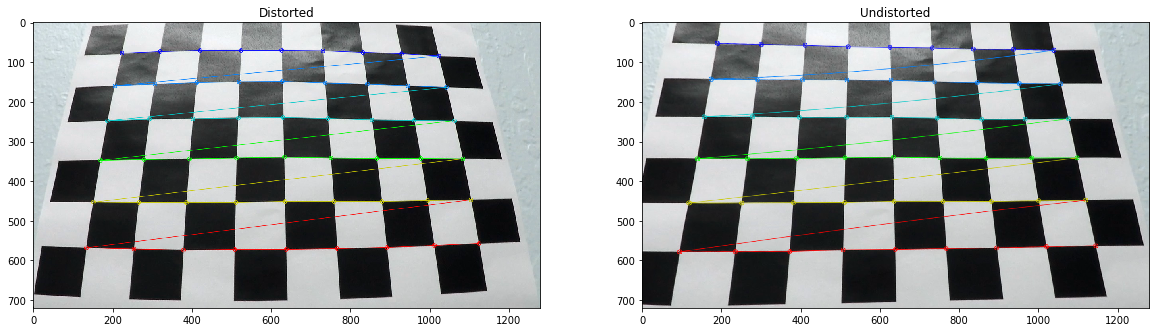

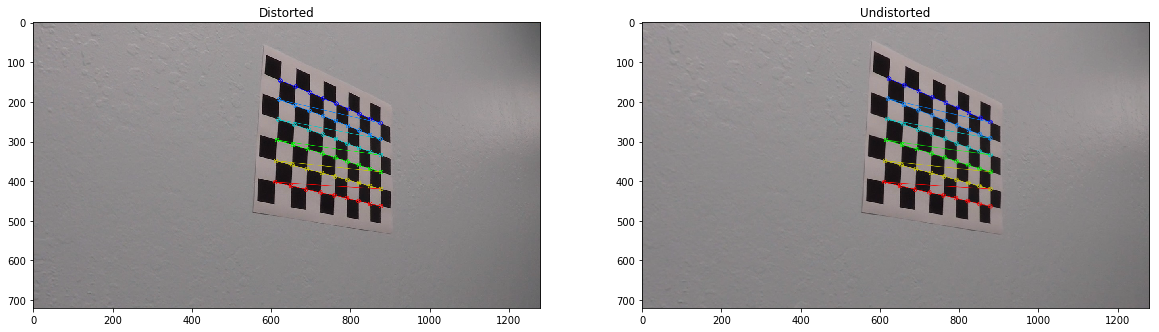

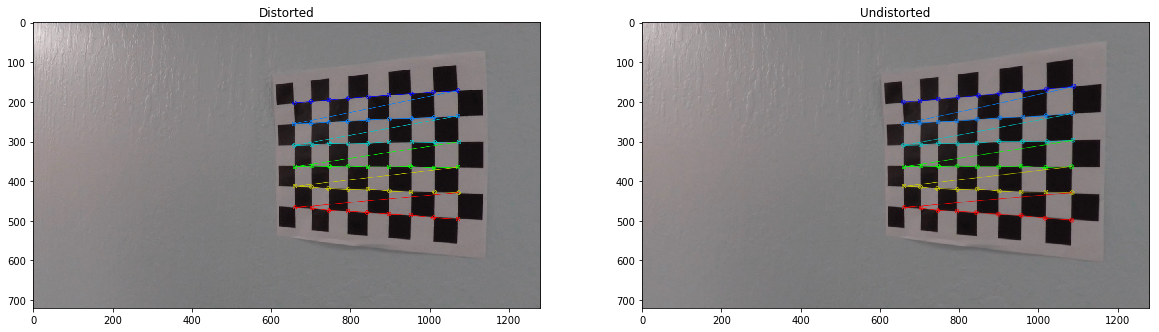

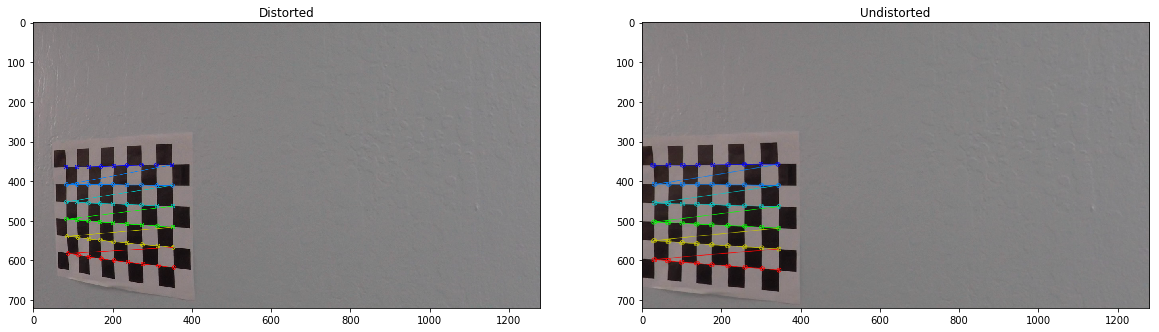

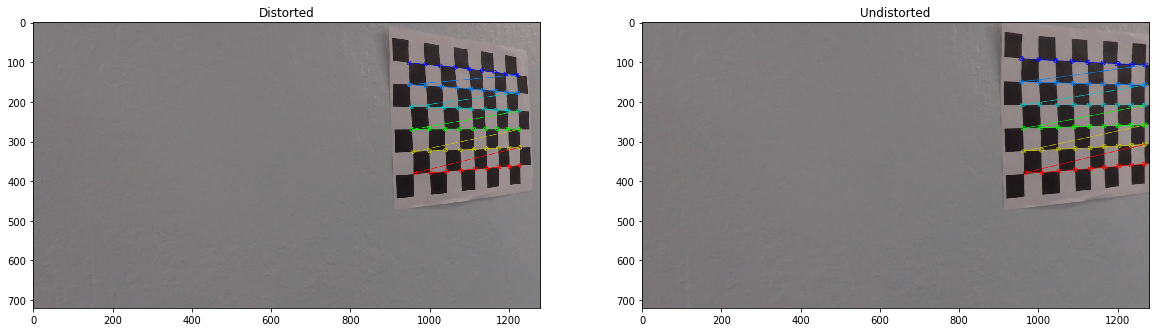

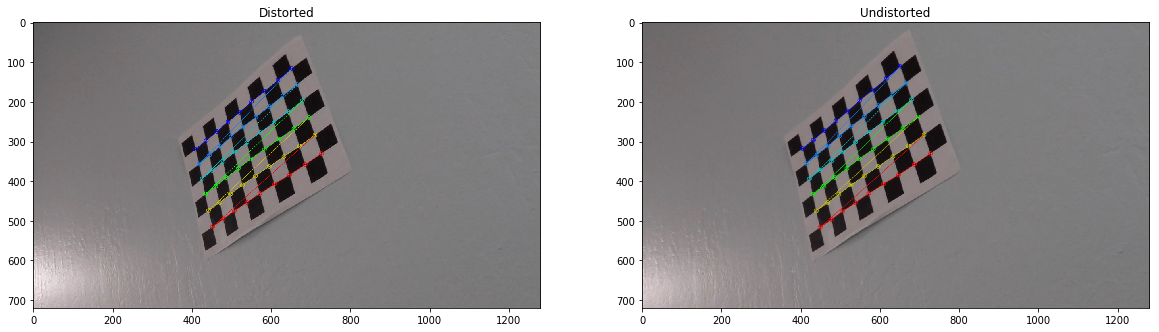

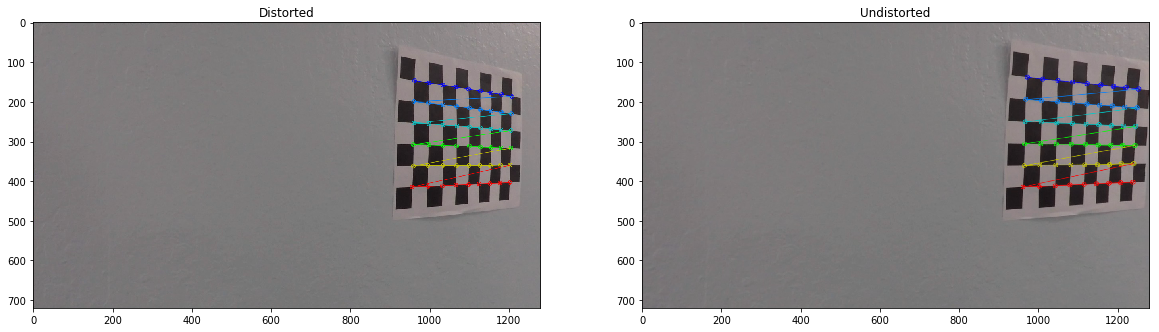

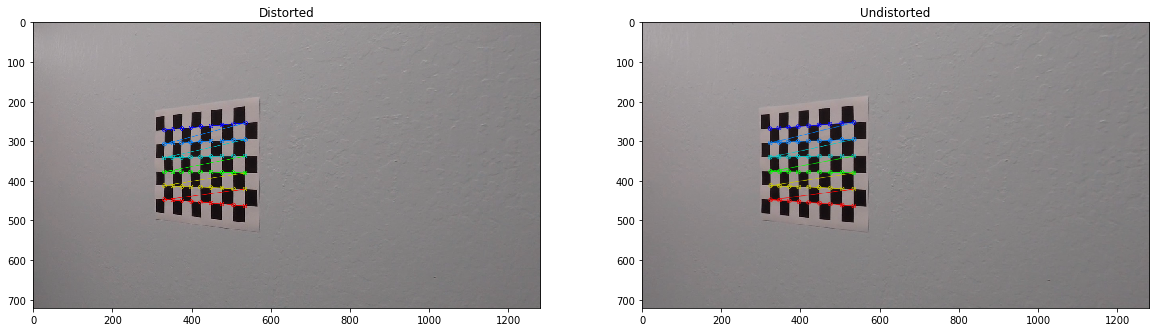

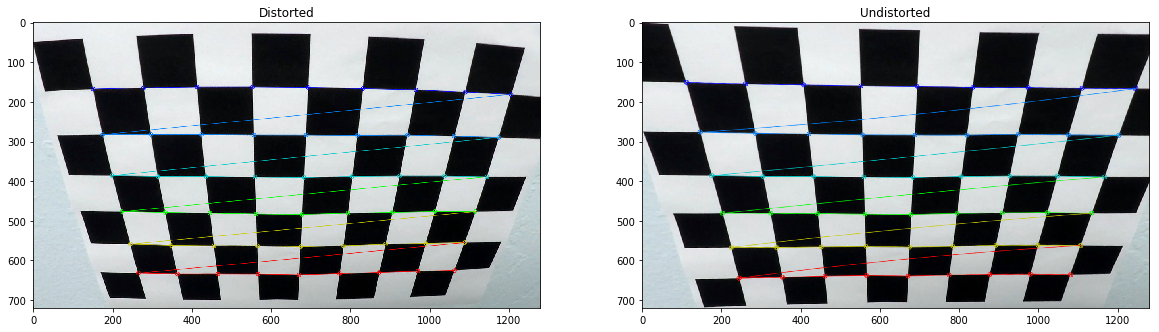

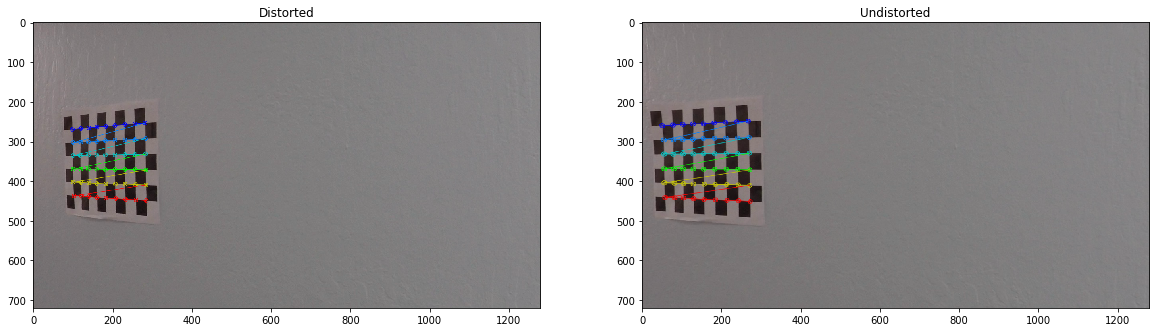

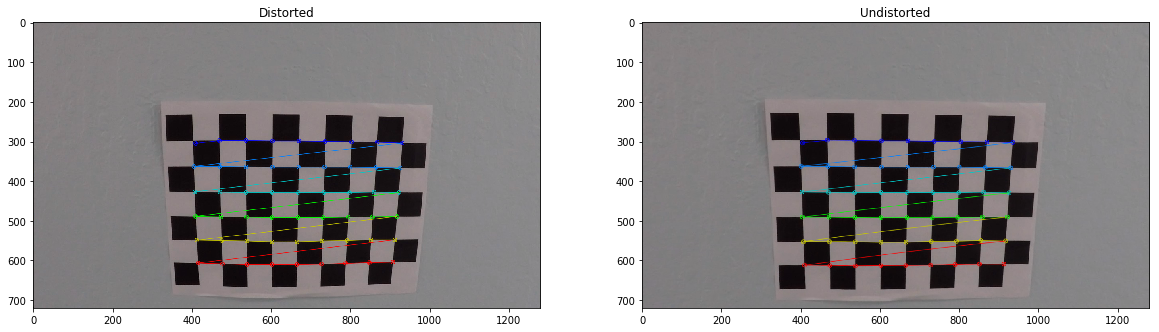

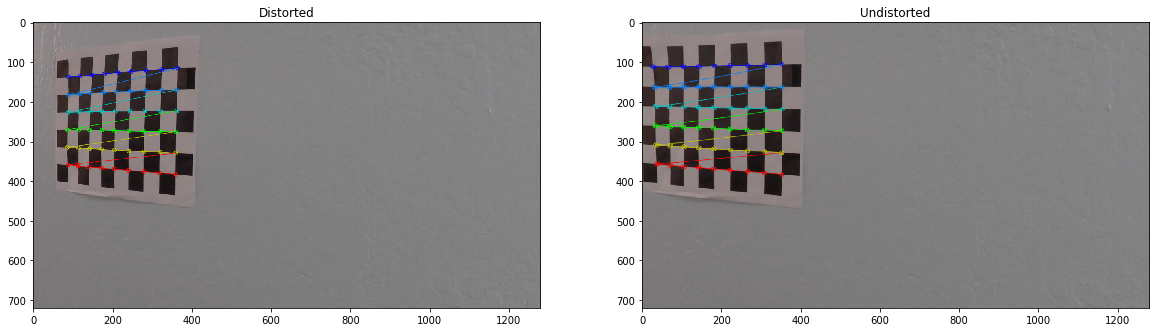

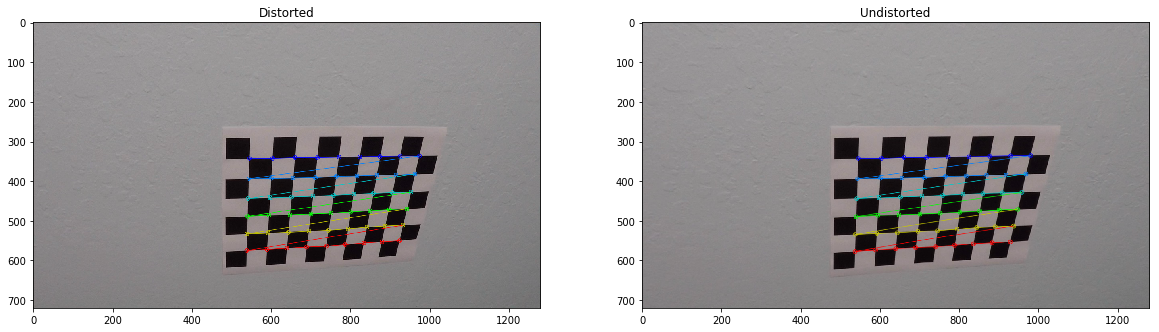

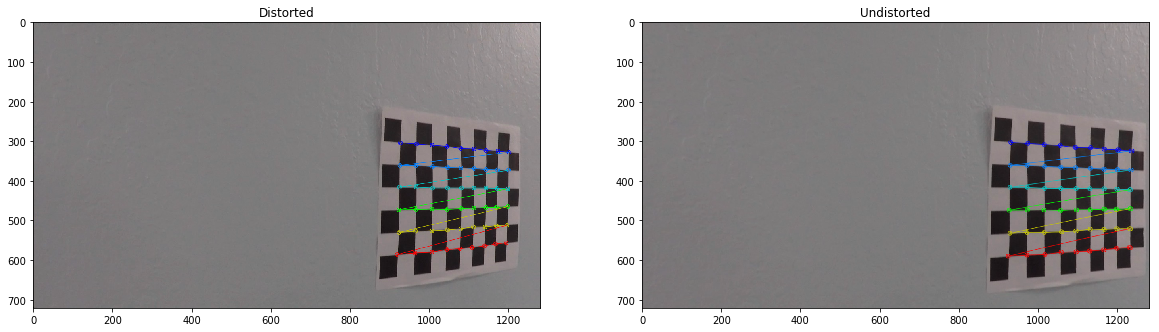

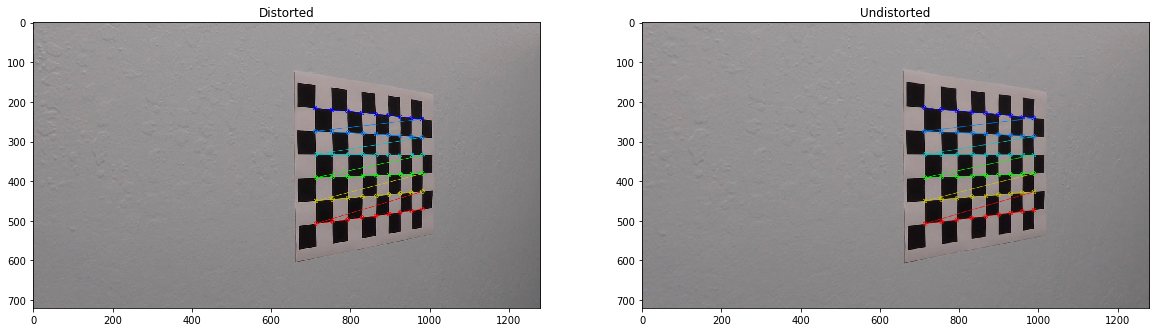

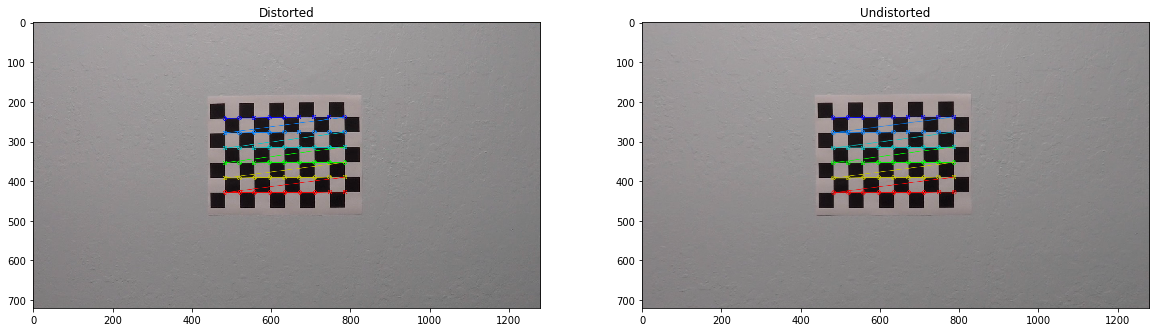

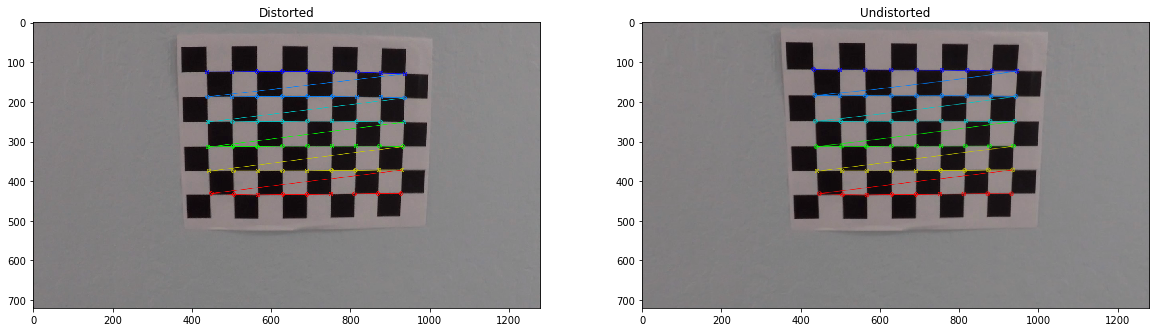

In [11]:
nx = 9
ny = 6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
# 3d points in real world space
objpoints = []
# 2d points in image plane.
imgpoints = []

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)

    # Transfer to Gray Scale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
        # Calibrate camera and calculate mtx and dist parameters
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        dst = cv2.undistort(img, mtx, dist, None, mtx)

        # Draw Distorted vs Undistorted images
        fig, axes = plt.subplots(nrows = 1,ncols=2, figsize=(20, 10))
        axes[0].imshow(img)
        axes[0].set_title('Distorted')
        axes[1].imshow(dst)
        axes[1].set_title('Undistorted')

        # Save the camera calibration result for later use
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump( dist_pickle, open( "camera_cal/camera_cal_pickle.p", "wb" ) )


### Image Pipeline consists of the following steps:
1 - Apply a distortion correction to raw images using camera calibration matrix and distortion coefficients previously calculated

2 - Calculate Adaptive threshold/Sobel threshold, H, L, S and generate combined image. I found adaptive threshold to be quite productive on the images.

Reference:
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html

3- Mark the region of interest from the combined image.

4 - Apply a perspective transform to rectify binary image ("birds-eye view").

5 - Detect lane pixels and fit to find the lane boundary.

6 - Determine the curvature of the lane and vehicle position with respect to center.

7 - Warp the detected lane boundaries back onto the original image.

8 - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [12]:
def Image_Pipeline(img):
    bgr_img = cv2.imread(img)
    
    # Convert to RGB Image
    rgb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    original_image = rgb_image
    
    # Calculate Width and height of image
    width = original_image.shape[1]
    height = original_image.shape[0]

    # Source Points for Image Warp
    src_coordinates = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right
    
    dst_coordinates = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right
    
    # Clear mtx and dist and load them from file camera_cal/camera_cal_pickle.p
    dist = 0
    mtx = 0
    
    # load the camera matrix and distortion coefficient
    dist_pickle = pickle.load( open( "camera_cal/camera_cal_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    # Undistort the image
    undistort_image = cv2.undistort(original_image, mtx, dist, None, mtx)

    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)

    # Calculate Adaptive threshold, H, L, S and generate combined image
    gray = cv2.cvtColor(undistort_image, cv2.COLOR_RGB2GRAY)
    adaptive_Thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,21,2)
    hlsBinary_h = hls_threshold(undistort_image, channel='h', thresh=(5, 40))# HLS H-channel Threshold
    hlsBinary_l = hls_threshold(undistort_image, channel='l', thresh=(200, 255))# HLS L-channel Threshold
    hlsBinary_s = hls_threshold(undistort_image, channel='s', thresh=(90, 255))# HLS S-channel Threshold  
    
    # Combine channel thresholds
    combined_image = np.zeros_like(hlsBinary_s)
    combined_image[((hlsBinary_h == 1) & (hlsBinary_s == 1)) | (hlsBinary_l == 1) | (adaptive_Thresh == 1)] = 1
    
    # Calculate Region of interest
    roi_image = region_of_interest(combined_image)
    
    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped_image = cv2.warpPerspective(roi_image, M, (width,height), flags=cv2.INTER_LINEAR)
    
    out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(warped_image)
    
    Minv = cv2.getPerspectiveTransform(dst_coordinates, src_coordinates)
    
    # Draw the lane lines found
    newwarp = draw_lanes(original_image, warped_image,left_fitx,right_fitx, ploty,Minv)
    
    final_image = cv2.addWeighted(undistort_image, 1, newwarp, 0.3, 0)
    
    # Calculate lanes Curvature and car offset
    curvead, pos = measure_curvature_pixels(final_image.shape[1], left_fitx, right_fitx, ploty)
    
    # Print the statistics to the image
    print_statistics_to_image(final_image, curvead, pos)
    
    
    f, axes= plt.subplots(1,5,figsize=(15,30))
    
    # Visualize Undistorted Image
    axes[0].imshow(undistort_image)
    axes[0].set_title("Undistorted Image")
    
    # Visualize Warped Image
    axes[1].imshow(combined_image)
    axes[1].set_title("Combined Image")
    
    # Visualize Region of Interest
    axes[2].imshow(roi_image)
    axes[2].set_title("ROI Image")
    
    # Visualize Warped Image
    axes[3].imshow(out_img)
    axes[3].set_title("Warped Image")
    
    # Visualize Final Image to be saved
    axes[4].imshow(final_image)
    axes[4].set_title("Final Image") 
    
    # Extract name of image to be stored from path
    name = os.path.basename(img)
    # Convert to BGR
    bgr_img = cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR)
    
    # Save warped images to warped_images folder
    cv2.imwrite('warped_images/' + name,out_img)
    
    # Save final images to output_images folder
    cv2.imwrite('output_images/' + name,bgr_img)

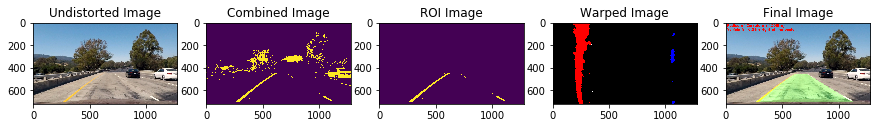

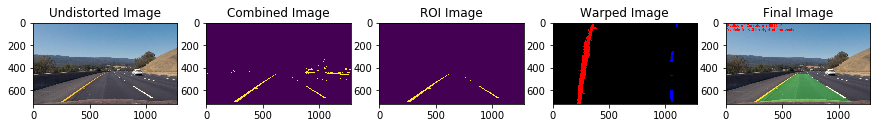

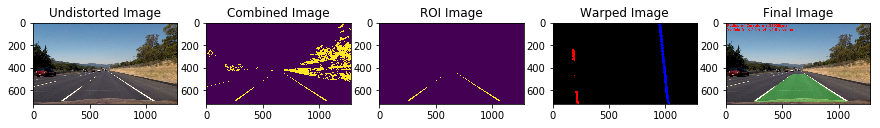

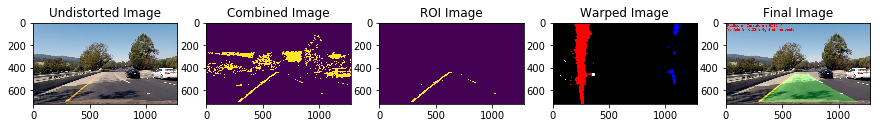

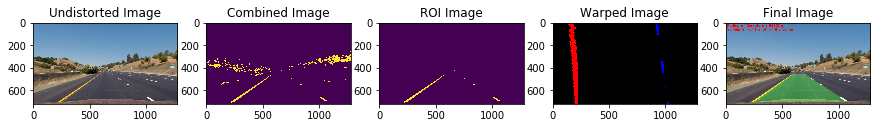

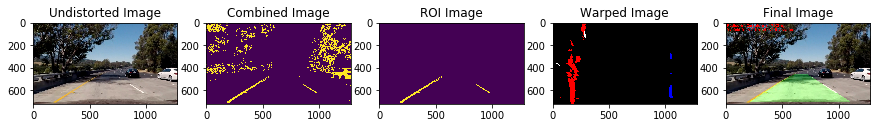

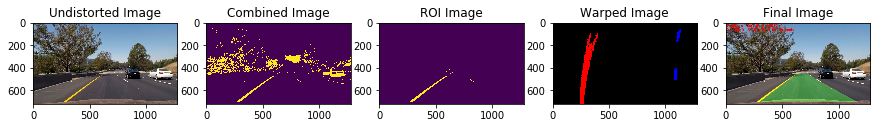

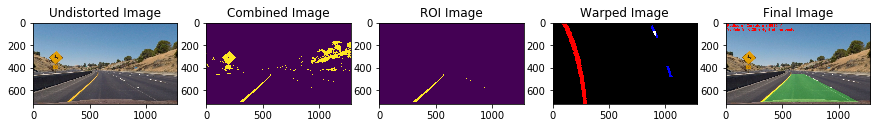

In [13]:
# Reading Images from test_images folder
test_images = glob.glob('test_images/*.jpg')

for fname in test_images:
    Image_Pipeline(fname)

In [15]:
def Video_Pipeline(img):
    global is_First_Frame
    global left_fit
    global right_fit
    
    original_image = img
    
    # Calculate Width and height of image
    width = original_image.shape[1]
    height = original_image.shape[0]
    
    # Source Points for Image Warp
    src_coordinates = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right
    
    dst_coordinates = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right
    
    # Clear mtx and dist and load them from file camera_cal/camera_cal_pickle.p
    dist = 0
    mtx = 0
    
    # load the camera matrix and distortion coefficient
    dist_pickle = pickle.load( open( "camera_cal/camera_cal_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    # Undistort the image
    undistort_image = cv2.undistort(original_image, mtx, dist, None, mtx)

    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
    
    # Calculate Adaptive threshold, H, L, S and generate combined image
    gray = cv2.cvtColor(undistort_image, cv2.COLOR_RGB2GRAY)
    adaptive_Thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,21,2)
    hlsBinary_h = hls_threshold(undistort_image, channel='h', thresh=(5, 40))# HLS H-channel Threshold
    hlsBinary_l = hls_threshold(undistort_image, channel='l', thresh=(200, 255))# HLS L-channel Threshold
    hlsBinary_s = hls_threshold(undistort_image, channel='s', thresh=(90, 255))# HLS S-channel Threshold  
    
    # Combine channel thresholds
    combined_image = np.zeros_like(hlsBinary_s)
    combined_image[((hlsBinary_h == 1) & (hlsBinary_s == 1)) | (hlsBinary_l == 1) | (adaptive_Thresh == 1)] = 1
    
    # Calculate Region of interest
    roi_image = region_of_interest(combined_image)
    
    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped_image = cv2.warpPerspective(roi_image, M, (width,height), flags=cv2.INTER_LINEAR)
    
    # Fit a polynomial function ( Blind search(First frame) or Search around previously detected lanes)
    out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(warped_image,is_First_Frame, left_fit, right_fit)
    
    Minv = cv2.getPerspectiveTransform(dst_coordinates, src_coordinates)
    
    # Draw lane lines on the image
    newwarp = draw_lanes(original_image, warped_image,left_fitx,right_fitx, ploty,Minv)
    final_image = cv2.addWeighted(undistort_image, 1, newwarp, 0.3, 0)
    
    # Calculate Curvature and Car offset from center
    curvead, offset = measure_curvature_pixels(final_image.shape[1], left_fitx, right_fitx, ploty)
    
    # Print statistics to the final image
    print_statistics_to_image(final_image, curvead, offset)
    
    # Last step clear the is_First_Frame flag we do not need to blindly search for lanes again,
    # we can search around the previous detected lanes +/- a margin (hyper parameter)
    is_First_Frame = False
    
    return final_image

In [16]:
is_First_Frame = True
left_fit = 0
right_fit = 0

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(0,10)

processed_video = video_input1.fl_image(Video_Pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:24<00:00,  4.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 13s, sys: 3.12 s, total: 2min 16s
Wall time: 4min 27s
